In [1]:
import sys
import os

# Add the root directory to the sys.path
sys.path.insert(0, os.path.abspath(os.path.dirname(os.getcwd())))

In [2]:
from torch import nn
import torch

In [3]:
from core.configurations.base import BaseConfiguration

config = BaseConfiguration(model_name="small_lm", num_layers=2, hidden_dim=32, intermediate_dim=64,
                               max_positions=256, vocabulary_size=64000, num_heads=2, attention_dropout=0.05,
                               batch_size=8, weight_decay=0.01,
                               learning_rate=5e-4,
                               tokenizer_path="/workspace/vipin_g6/personal/pretraining/english_tokenizer/english_tokenizer.model",
                               dataset_batch_size=16, dataset_shuffle=True, num_epochs=2, eval_frequency=1,
                               eval_iter=10,
                               model_max_sequence=256)

In [4]:
embedding = nn.Embedding(num_embeddings=config.vocabulary_size, embedding_dim=config.hidden_dim, padding_idx=config.padding_id)

In [5]:
dumpy_input = torch.randint(1, 1000, (3, 10,))
attention_mask = torch.ones_like(dumpy_input)

dumpy_input[0, 5:] = 0
dumpy_input[1, 8:] = 0
dumpy_input = dumpy_input.long()

attention_mask[0, 5:] = 0
attention_mask[1, 8:] = 0

print("Dummy Input Shape :: ", dumpy_input.shape)
print("Input Tensor:")
print(dumpy_input)
print()
print("Attention Mask:")
print(attention_mask)

Dummy Input Shape ::  torch.Size([3, 10])
Input Tensor:
tensor([[326, 814,  65, 400, 351,   0,   0,   0,   0,   0],
        [925, 279, 903,  63, 229, 660, 334, 324,   0,   0],
        [864, 977, 264, 554, 314, 823, 605, 664, 117, 221]])

Attention Mask:
tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [6]:
hidden_state = embedding(dumpy_input)
print("Input id embedding value :: ", hidden_state.shape)

Input id embedding value ::  torch.Size([3, 10, 32])


## Decoder Layer

## Layer Norm

In [7]:
import numbers
import torch
from torch import nn
import torch.nn.functional as F

class LayerNorm(nn.Module):
    """
    Class the contains LayerNorm
    This is same as transformers implementation
    """
    def __init__(self, model_dimension, epsilon=0.00001):
        super(LayerNorm, self).__init__()
        if isinstance(model_dimension, numbers.Integral):
            # mypy error: incompatible types in assignment
            model_dimension = (model_dimension,) 
        self.model_dimension = model_dimension
        self.gamma = nn.Parameter(torch.ones(model_dimension))
        self.beta = nn.Parameter(torch.zeros(model_dimension))
        self.epsilon = epsilon


    def forward(self, x):
        if isinstance(x, tuple):
            x = x[0]
        return F.layer_norm(
            x, self.model_dimension, self.gamma, self.beta, self.epsilon
        )
        


In [8]:
layer_norm = LayerNorm(config.hidden_dim)
output = layer_norm(hidden_state)
print("Output shape:", output.shape)
print("Mean (last dimension):", output.mean(dim=-1))
print("Std (last dimension):", output.std(dim=-1))


Output shape: torch.Size([3, 10, 32])
Mean (last dimension): tensor([[-1.1176e-08,  1.3039e-08, -3.7253e-08, -2.6077e-08, -2.8871e-08,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.4901e-08, -2.2352e-08, -2.2352e-08,  0.0000e+00, -3.7253e-09,
         -1.4901e-08, -1.8626e-08,  3.7253e-08,  0.0000e+00,  0.0000e+00],
        [ 2.2352e-08,  0.0000e+00, -7.4506e-09,  7.4506e-09,  1.3039e-08,
         -3.7253e-09,  1.8626e-09,  7.4506e-09,  2.2352e-08,  0.0000e+00]],
       grad_fn=<MeanBackward1>)
Std (last dimension): tensor([[1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 0.0000,
         0.0000],
        [1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160, 1.0160,
         1.0160]], grad_fn=<StdBackward0>)


In [9]:
from typing import Optional, Tuple

from torch import Tensor


def create_causal_mask(
    attention_mask,
    shape: Tuple[int, ...],
    dtype: torch.dtype,
    device: torch.device
) -> Tensor:
    """
    Efficiently creates a causal mask without redundant computations.
    """
    seq_len = shape[-1]
    batch_size = shape[0]
    mask = torch.triu(
        torch.ones(seq_len, seq_len, dtype=dtype, device=device),
        diagonal=1
    )
    
    # Directly create with -inf instead of using masked_fill
    causal_mask = mask.masked_fill(mask > 0, float('-inf'))
    
    # Expand to match input shape
    if len(shape) == 4:  # [B, H, S, S]
        causal_mask = causal_mask.view(1, 1, seq_len, seq_len)
    else:  # [B, S, S]
        causal_mask = causal_mask.view(1, seq_len, seq_len)
    
    if attention_mask is not None:
        if len(shape) == 4:
            attention_mask = attention_mask.view(batch_size, 1, 1, seq_len)
        else:
            attention_mask = attention_mask.view(batch_size, 1, seq_len)
        
        mask_value = torch.finfo(dtype).min
        causal_mask = causal_mask.masked_fill(attention_mask == 0, mask_value)
    return causal_mask

In [93]:
causal_mask = create_causal_mask(
    attention_mask,
    dumpy_input.shape,
    hidden_state.dtype,
    hidden_state.device,
)

print("Causal Mask Shape :: ", causal_mask.shape)

Causal Mask Shape ::  torch.Size([3, 10, 10])


/root/anaconda3/envs/ai_experimentation_env/lib/python3.11/site-packages/matplotlib/colors.py:1405: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/root/anaconda3/envs/ai_experimentation_env/lib/python3.11/site-packages/matplotlib/colors.py:1405: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/root/anaconda3/envs/ai_experimentation_env/lib/python3.11/site-packages/matplotlib/colors.py:1405: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


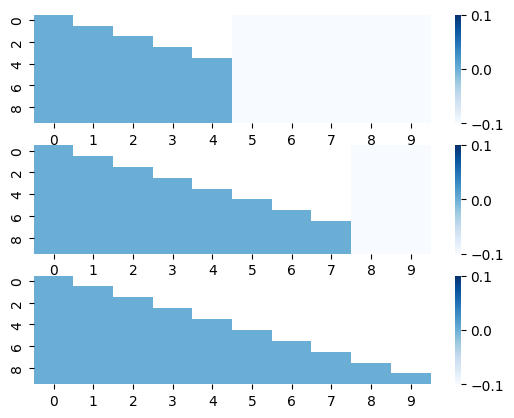

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axes = plt.subplots(3)

sns.heatmap(causal_mask[0, :, :], cmap="Blues", ax=axes[0])
sns.heatmap(causal_mask[1, :, :], cmap="Blues", ax=axes[1])
sns.heatmap(causal_mask[-1, :, :], cmap="Blues", ax=axes[2])

plt.show()
        

#### Rope Positional Embedding + Attention 


for rope positional embedding implementation details see, `study/rope_positional_encoding.ipynb`

In [12]:
from core.layers.positional_embedding.rope_projector import RopePositionEmbedding
from core.layers.positional_embedding.rope_projector import apply_positional_embedding



In [ ]:
import math


class RopeAttention(nn.Module):
    """
    Implements attention mechanism with Rotary Position Embedding (RoPE).
    """
    
    def __init__(self, config: BaseConfiguration):
        super().__init__()
        assert config.head_dim is not None
        if config.hidden_dim % config.head_dim != 0:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )
        
        self.config = config
        self.attention_dropout = config.attention_dropout
        self.hidden_dim = config.hidden_dim
        self.num_heads = config.num_heads
        self.head_dim = config.head_dim
        self.scaling = 1 / math.sqrt(config.head_dim)
        
        # Initialize RoPE if enabled
        self.use_rope = config.use_rope
        if self.use_rope:
            self.rope_position_projection = RopePositionEmbedding(
                hidden_dim=config.head_dim,
                max_positions=config.max_positions,
                base=config.rope_base
            )
        
        # Initialize projection layers
        self.qkv_projection = nn.Linear(
            config.hidden_dim,
            3 * config.hidden_dim,
            bias=False
        )
        
        self.output_projection = nn.Linear(
            config.hidden_dim,
            config.hidden_dim,
            bias=False
        )
    
    def forward(
        self,
        input_tensor: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        positions: Optional[torch.Tensor] = None,
        output_attentions: bool = False
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Forward pass for RoPE attention.
        
        Args:
            input_tensor: Input tensor [batch_size, seq_len, hidden_dim]
            attention_mask: Optional attention mask [batch_size, seq_len]
            positions: Optional position indices
            output_attentions: Whether to return attention weights
        
        Returns:
            Tuple of (output tensor, optional attention weights)
        """
        if input_tensor.dim() != 3:
            raise ValueError(f"Expected 3D input, got {input_tensor.dim()}D")
        
        batch_size, seq_length, _ = input_tensor.shape
        
        # Fused QKV projection
        qkv = self.qkv_projection(input_tensor)
        qkv = qkv.view(batch_size, seq_length, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, seq_len, head_dim]
        query_states, key_states, value_states = qkv
        
        # Apply RoPE if enabled
        if self.use_rope:
            cos, sin = self.rope_position_projection(query_states)
            query_states, key_states = apply_positional_embedding(
                query_states, key_states, cos, sin
            )
        
        # Compute attention scores with improved numerical stability
        attn_weights = torch.matmul(query_states, key_states.transpose(-2, -1))
        attn_weights = attn_weights * self.scaling
        
        # Apply attention mask if provided
        if attention_mask is not None:
            # Convert mask to proper dtype
            attention_mask = attention_mask.to(dtype=query_states.dtype)
            
            # Add head dimension if needed
            if attention_mask.dim() == 3:
                attention_mask = attention_mask.unsqueeze(1)
            
            # Ensure proper sequence length
            attention_mask = attention_mask[:, :, :, :key_states.shape[-2]]
            
            attn_weights = attn_weights + attention_mask
        
        # Compute attention probabilities with improved numerical stability
        attn_weights_float = F.softmax(attn_weights, dim=-1, dtype=torch.float32)
        attn_weights = attn_weights_float.to(query_states.dtype)
        
        # Apply dropout during training
        if self.training:
            attn_weights = F.dropout(
                attn_weights,
                p=self.attention_dropout,
                training=True
            )
        
        # Compute attention output
        attn_output = torch.matmul(attn_weights, value_states)
        
        # Validate output shape
        expected_shape = (batch_size, self.num_heads, seq_length, self.head_dim)
        if attn_output.shape != expected_shape:
            raise ValueError(
                f"Expected output shape {expected_shape}, got {attn_output.shape}"
            )
        
        # Reshape output and apply output projection
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, seq_length, self.hidden_dim)
        attn_output = self.output_projection(attn_output)
        
        return attn_output, (attn_weights if output_attentions else None)

In [22]:
attention_layer = RopeAttention(config=config)

In [38]:
output, attention = attention_layer(
    hidden_state,
    causal_mask,
    output_attentions=True
)

print("Attention Output shape :: ", output.shape)

Attention Output shape ::  torch.Size([3, 10, 32])


<Axes: >

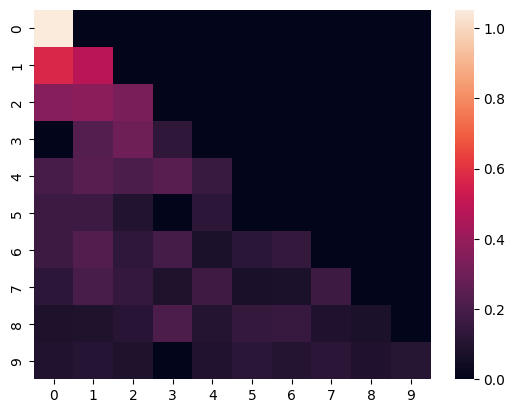

In [39]:
sns.heatmap(attention[-1][1].detach().numpy())

In [40]:
import torch
from torch import nn
from core.configurations.base import BaseConfiguration

from core.activations.gelu import PytorchGELUTanh


class PointWiseProjection(nn.Module):
    """
    point wise project as native from `attention is all you need`
    with slight changes in activation relu -> gelu tanh approximation
    https://arxiv.org/pdf/1706.03762
    """
    def __init__(self, config: BaseConfiguration):
        super().__init__()
        self.up_projection = nn.Linear(config.hidden_dim, config.intermediate_dim, bias=False)
        self.down_projection = nn.Linear(config.intermediate_dim, config.hidden_dim, bias=False)
        self.act_func = PytorchGELUTanh()


    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.down_projection(self.act_func(self.up_projection(input_tensor)))
    
    

class PointWiseGatedProjection(nn.Module):
    """
    point wise project as native from `attention is all you need`
    with slight changes in activation relu -> gelu tanh approximation
    https://arxiv.org/pdf/1706.03762
    """

    def __init__(self, config: BaseConfiguration):
        super().__init__()
        self.intermediate_size = config.intermediate_dim
        # print(f"## config hidden dim {config.hidden_dim}")
        # print(f"## config intermediate dim {config.intermediate_dim}")
        self.gate_projection = nn.Linear(config.hidden_dim, config.intermediate_dim, bias=False)
        self.up_projection = nn.Linear(config.hidden_dim, config.intermediate_dim, bias=False)
        self.down_projection = nn.Linear(config.intermediate_dim, config.hidden_dim, bias=False)
        
        self.act_func = PytorchGELUTanh()

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.down_projection(self.act_func(self.gate_projection(input_tensor)) * self.up_projection(input_tensor))


In [41]:
projection_layer = PointWiseGatedProjection(config=config)

In [44]:
projection_output = projection_layer(output)

print("Projection Output shape :: ", projection_output.shape)

Projection Output shape ::  torch.Size([3, 10, 32])


In [45]:
class DecoderLayer(nn.Module):
    def __init__(self, base_cfg: BaseConfiguration):
        super().__init__()

        self.input_norm = LayerNorm(model_dimension=base_cfg.hidden_dim)
        self.self_attn = RopeAttention(
            config=base_cfg
        )
        self.attention_dropout = nn.Dropout(p=base_cfg.attention_dropout)

        self.post_attention_norm = LayerNorm(model_dimension=base_cfg.hidden_dim)
        self.mlp = PointWiseGatedProjection(config=base_cfg)
        self.dropout2 = nn.Dropout(p=base_cfg.attention_dropout)


    def forward(self, hidden_state, attention_mask, output_attentions=False):
        """
         https://arxiv.org/pdf/2002.04745 (PRE-Norm)


        x = embedding of each tokens (B x S x D)
        mask = self_attention autput (B x S x D)

        Self-attention sub-block 1
        x => norm(x) => n_x => att(n_x) => (a_x, a_score) => a_x + x => h_x

        MLP sub-block: 2

        h_x => norm(h_x) => n_hx => mlp(n_hx) => n_x => x_x + h_x => h_x
        """
        residual_x = hidden_state

        hidden_state = self.input_norm(hidden_state)
        hidden_state, self_attn_weights = self.self_attn(
            input_tensor=hidden_state,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
        )
        hidden_state = self.attention_dropout(hidden_state)
        hidden_state = residual_x + hidden_state

        residual_x = hidden_state

        hidden_state = self.post_attention_norm(hidden_state)
        hidden_state = self.mlp(hidden_state)
        hidden_state = self.dropout2(hidden_state)
        hidden_state = residual_x + hidden_state

        return hidden_state, self_attn_weights



In [46]:
decoder_layer = DecoderLayer(config)

In [51]:
decoder_output, attentions = decoder_layer(hidden_state,
              causal_mask, output_attentions=True)

In [101]:
class Model(nn.Module):
    def __init__(self, config: BaseConfiguration):
        super().__init__()

        self.config = config

        self.token_embeddings = nn.Embedding(
            num_embeddings=config.vocabulary_size,
            embedding_dim=config.hidden_dim,
            padding_idx=config.padding_id
        )

        # Decoder layer stack
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(
                config
            )
            for _ in range(config.num_layers)
        ])

        # Layer Norm initialization
        self.final_layer_norm = LayerNorm(
            model_dimension=config.hidden_dim
        )

    def forward(self, input_tensor, attn_mask=None, output_attentions=False):
        if attn_mask is None:
            attn_mask = torch.ones_like(input_tensor)

        hidden_states = self.token_embeddings(input_tensor)
        print(attn_mask.shape)
        causal_mask = create_causal_mask(
            attention_mask=attn_mask,
            shape=input_tensor.shape,
            dtype=hidden_state.dtype,
            device=hidden_state.device
        )


        output_attentions_weights = ()
        for decoder_layer in self.decoder_layers:
            hidden_states, attention_weight = decoder_layer(
                hidden_states,
                causal_mask,
                output_attentions=output_attentions
            )
            output_attentions_weights += (attention_weight,)

        hidden_states = self.final_layer_norm(hidden_states)

        return hidden_states, (output_attentions_weights if output_attentions else None)

In [102]:
model = Model(config)

In [103]:
output, attentions = model(dumpy_input, attention_mask, True)

torch.Size([3, 10])


In [104]:
output.shape

torch.Size([3, 10, 32])

In [105]:
from core.trainer.validator import validate_model_initial_states

In [ ]:

validate_model_initial_states(model, config=config, input_size=(10,), n_samples=10000)


Initialization Statistics:

token_embeddings:
Mean: -0.000425
Std:  0.999283
Min:  -4.689465
Max:  4.892149
Near zero: 0.00%

decoder_layers.0.self_attn.qkv_projection:
Mean: 0.001068
Std:  0.103101
Min:  -0.176547
Max:  0.176750
Near zero: 0.00%

decoder_layers.0.self_attn.output_projection:
Mean: -0.001130
Std:  0.103176
Min:  -0.176758
Max:  0.175817
Near zero: 0.00%

decoder_layers.0.mlp.gate_projection:
Mean: 0.000397
Std:  0.101356
Min:  -0.176768
Max:  0.176636
Near zero: 0.00%

decoder_layers.0.mlp.up_projection:
Mean: -0.000113
Std:  0.102286
Min:  -0.176508
Max:  0.176717
Near zero: 0.00%

decoder_layers.0.mlp.down_projection:
Mean: -0.000708
Std:  0.071396
Min:  -0.124769
Max:  0.124804
Near zero: 0.00%

decoder_layers.1.self_attn.qkv_projection:
Mean: 0.005238
Std:  0.101242
Min:  -0.176656
Max:  0.176754
Near zero: 0.00%

decoder_layers.1.self_attn.output_projection:
Mean: -0.005065
Std:  0.101385
Min:  -0.175676
Max:  0.176358
Near zero: 0.00%

decoder_layers.1.mlp.gate_

In [108]:
import torch
import math
import numpy as np

def calculate_gelu_gain():
    """
    Calculates the gain for GELU activation with tanh approximation.
    Uses numerical differentiation to find the variance preservation factor.
    """
    def gelu(x):
        # GELU with tanh approximation
        return x * 0.5 * (1 + torch.tanh(math.sqrt(2/math.pi) * (x + 0.044715 * x**3)))
    
    # Generate random input samples
    num_samples = 1000000
    x = torch.randn(num_samples)
    
    # Calculate numerical derivative
    epsilon = 1e-6
    x_plus = x + epsilon
    x_minus = x - epsilon
    derivative = (gelu(x_plus) - gelu(x_minus)) / (2 * epsilon)
    
    # Calculate variance of derivative (gain is square root of this)
    gain = float(torch.sqrt(torch.mean(derivative**2)))
    
    return gain

gain = calculate_gelu_gain()
print(f"GELU (tanh approximation) gain: {gain:.4f}")

GELU (tanh approximation) gain: 0.6666
